In [1]:
# 授权绑定Google Drive 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 113597 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [2]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/Acoustic_Localization/keras/data/data_19_1") 


# 查看文件目录，是否包含所需的文件
!ls

drive  qd_LOS_32_berlin_20k.mat  qd_NLOS_32_berlin_20k.mat  v_LOS_32_20k.mat


In [1]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras import backend as KK
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers
from numpy import linalg as LA

Using TensorFlow backend.


In [2]:
#loading data
DDataFile = './data/data_Emre/v_LOS_32_20k.mat'
DData = sio.loadmat(DDataFile)
#get the coeff data
h_coeff = DData['h_coeff']
location = DData['positions']
#split the D_data and location_data and only need the first 2k
N = 20000
M = 32
h_coeff = h_coeff[:,:N]
loc = np.transpose(location[:,:N])
print("h_coeff shape", h_coeff.shape)
print("loc shape", loc.shape)

D = np.asmatrix(np.fft.fft(np.eye(M)/np.sqrt(M)))
DH = D.H
F = np.zeros([N, M * M], dtype = "complex_")

for i in range(N):
    h = np.asmatrix(h_coeff[:, i:i+1])
    v = (M **(1 / 6.0) / LA.norm(h, 2)) **(4/3.) * h
#     hH = h.H
    K = v * v.H
    B = D * K * DH
    F[i] =B.flatten().A
F = np.asarray(F)
print(F.shape)
print(type(F))


h_coeff shape (32, 20000)
loc shape (20000, 2)
(20000, 1024)
<class 'numpy.ndarray'>


In [3]:

# real_D = np.real(F)
# img_D = np.imag(F)

ft = np.angle(F) # get the absolute of the F data

print("ft shape", ft.shape, type(ft))

print(F.shape,loc.shape)
total, l = F.shape
total, d = loc.shape

train_length = int(np.floor(total * 0.8))

impulses_train = ft[:train_length, :]
location_train = loc[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = ft[train_length:, :]
location_test = loc[train_length:,:]

 
print('impulses_train shape:', impulses_train.shape)
print('impulses_test shape:', impulses_test.shape)
print('location_train shape:', location_train.shape)
print('location_test shape:', location_test.shape)

ft shape (20000, 1024) <class 'numpy.ndarray'>
(20000, 1024) (20000, 2)
20000 16000 (16000, 1024) (16000, 2)
impulses_train shape: (16000, 1024)
impulses_test shape: (4000, 1024)
location_train shape: (16000, 2)
location_test shape: (4000, 2)


In [4]:
#Build the model
model = keras.Sequential()

#model.add(keras.layers.normalization.BatchNormalization())

model.add(Dense(1024, activation = 'relu'))   #the hidden layer number 

model.add(keras.layers.normalization.BatchNormalization())

model.add(Dense(512, activation = 'relu')) 

model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [5]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam() #'Adam'  lr=0.001  #  RMSprop() sgd()  Adadelta()   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )


print(impulses_train.shape, location_train.shape)
print(type(impulses_train))

(16000, 1024) (16000, 2)
<class 'numpy.ndarray'>


In [6]:
#Train the model, iterating
print(impulses_train.shape, location_train.shape)
print(impulses_test.shape, location_test.shape)

history = model.fit(impulses_train, location_train,
                    batch_size = 100, # 50 -> 52138; 20->52088
                    epochs = 100,
                    verbose = 1,
                    validation_split = 0.1 #0.2
#                     validation_data=(impulses_test,location_test)
                   )


(16000, 1024) (16000, 2)
(4000, 1024) (4000, 2)
Train on 14400 samples, validate on 1600 samples
Epoch 1/100
14400/14400 [==============================] - 4s 281us/step - loss: 29235.3479 - val_loss: 11498.1045
Epoch 2/100
14400/14400 [==============================] - 4s 255us/step - loss: 11666.3313 - val_loss: 8299.4940
Epoch 3/100
14400/14400 [==============================] - 4s 271us/step - loss: 8989.7682 - val_loss: 6890.1637
Epoch 4/100
14400/14400 [==============================] - 4s 245us/step - loss: 7584.8776 - val_loss: 6243.8459
Epoch 5/100
14400/14400 [==============================] - 3s 239us/step - loss: 6902.0603 - val_loss: 5616.8910
Epoch 6/100
14400/14400 [==============================] - 4s 248us/step - loss: 6298.0121 - val_loss: 5930.7900
Epoch 7/100
14400/14400 [==============================] - 4s 253us/step - loss: 5884.2635 - val_loss: 6040.4706
Epoch 8/100
14400/14400 [==============================] - 4s 255us/step - loss: 5622.2544 - val_loss: 4900.5

14400/14400 [==============================] - 4s 271us/step - loss: 2831.4674 - val_loss: 3858.8529
Epoch 73/100
14400/14400 [==============================] - 4s 270us/step - loss: 2823.8110 - val_loss: 3631.5393
Epoch 74/100
14400/14400 [==============================] - 4s 270us/step - loss: 2818.8885 - val_loss: 3748.9336
Epoch 75/100
14400/14400 [==============================] - 4s 268us/step - loss: 2745.1154 - val_loss: 3590.5793
Epoch 76/100
14400/14400 [==============================] - 4s 275us/step - loss: 2751.0246 - val_loss: 3742.1501
Epoch 77/100
14400/14400 [==============================] - 4s 278us/step - loss: 2865.9750 - val_loss: 3988.5450
Epoch 78/100
14400/14400 [==============================] - 4s 265us/step - loss: 2724.0810 - val_loss: 3689.3470
Epoch 79/100
14400/14400 [==============================] - 4s 267us/step - loss: 2720.8591 - val_loss: 3809.0324
Epoch 80/100
14400/14400 [==============================] - 4s 271us/step - loss: 2710.8036 - val_los

In [7]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

(4000, 2)
(4000, 2)
4000/4000 [==============================] - 1s 159us/step
Test loss & mean_absolute_error:  3734.7418203125


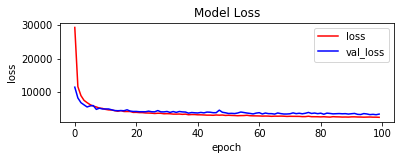

In [8]:
#plot the loss data
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()



# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# ax1.set_title('Location Scatter Plot')
# ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
# ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
# plt.legend()
# plt.show() 

error distance is  61.39137082620051
max error distance is  901.803626852734
min error distance is  0.18276249607948486


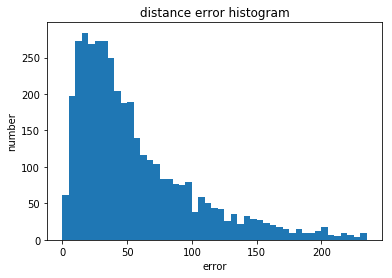

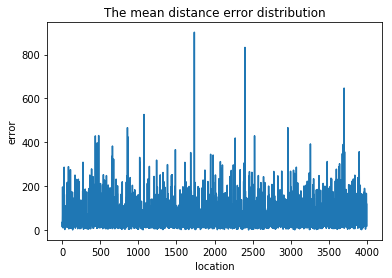

(4000, 1)

In [9]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,240,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

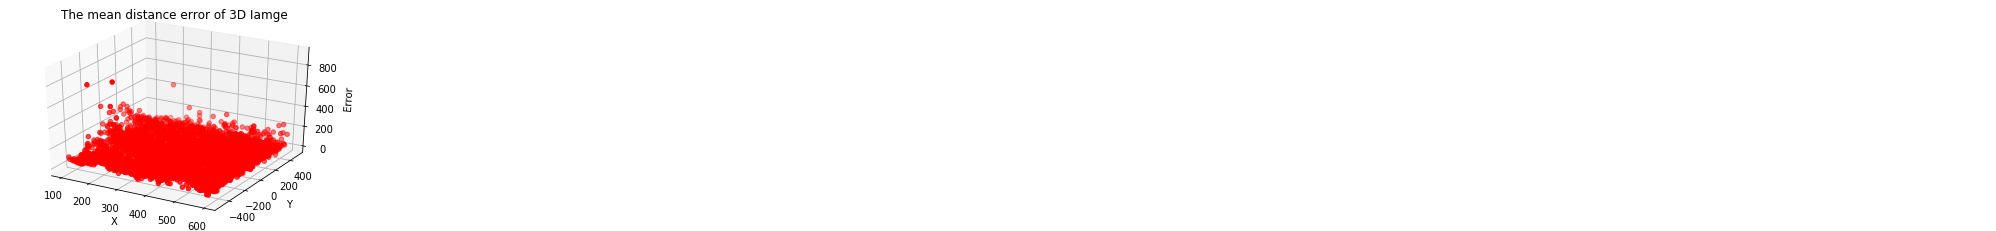

In [10]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

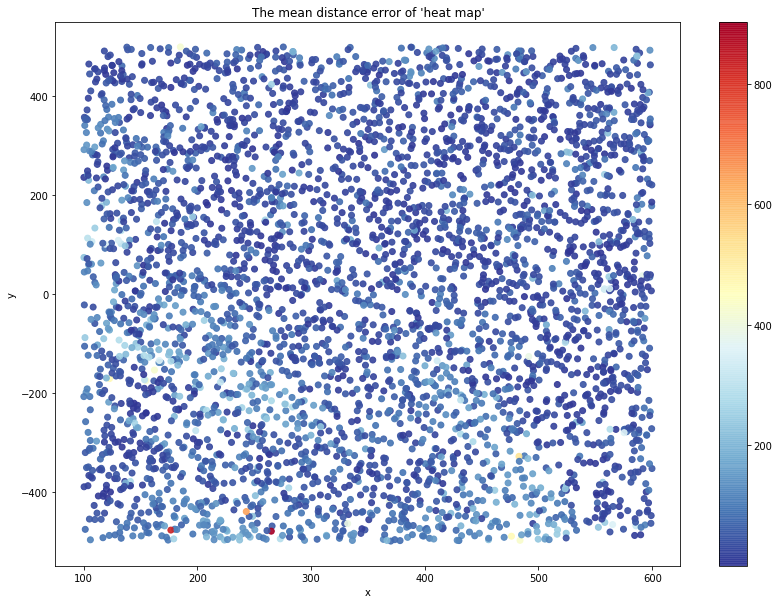

In [12]:
#draw the "heatmap" of error
fig = plt.figure(figsize=(14,10))
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.savefig("heat_map.png")

the mean of error 76.144185
the max of error 366.197220
the max of error 2.550153


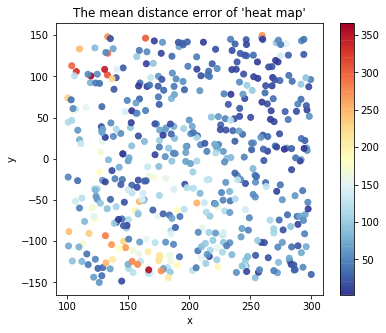

In [11]:
#plot small scale error map

err_map = np.hstack((location_test, err_dis))
err_map = pd.DataFrame(err_map, columns=['x', 'y', 'err'])
err_map_300 = err_map[err_map['x']<300]
err_map_300 = err_map_300[err_map_300['y']<150]
err_map_300 = err_map_300[err_map_300['y']>-150]
# np.array(err_map_300['x'])
print('the mean of error %f'% err_map_300['err'].mean())
print('the max of error %f'% err_map_300['err'].max())
print('the max of error %f'% err_map_300['err'].min())

fig = plt.figure(figsize=(6,5))
ax4 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r
sc = ax4.scatter(np.array(err_map_300['x']),np.array(err_map_300['y']),c = np.array(err_map_300['err']), marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")
plt.show()


Text(0.5, 1.0, 'distance error histogram')

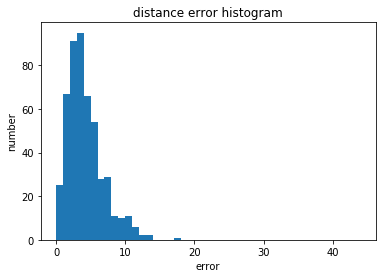

In [27]:

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(np.array(err_map_300['err']), bins =  range(0,45,1)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

## Conclusion :

number of layers| batch size | epoch | volidation | loss| error(average) | error(min)|
--|--|--|--|--|--|--|
3| 100| 100 | 0.1|1314.788985|22.5|0.23|
4| 100|100|0.1|1273.8396|24.5| 0.12|
batchnormalization 4| 100|100|0.1|overfitting|
batchnormalization 3| 100|100|0.1|82.426|8.4811|0.168|(BEST)
- three layers with mse batch size 100, epoch 100